In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#https://www.kaggle.com/datasets/elikplim/car-evaluation-data-set
df = pd.read_csv("data/13-car_evaluation.csv")
df.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [2]:
col_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]

In [3]:
df.columns = col_names
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1727 non-null   object
 1   maint     1727 non-null   object
 2   doors     1727 non-null   object
 3   persons   1727 non-null   object
 4   lug_boot  1727 non-null   object
 5   safety    1727 non-null   object
 6   class     1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [5]:
for i in df.columns:
    print(df[i].value_counts())

buying
high     432
med      432
low      432
vhigh    431
Name: count, dtype: int64
maint
high     432
med      432
low      432
vhigh    431
Name: count, dtype: int64
doors
3        432
4        432
5more    432
2        431
Name: count, dtype: int64
persons
4       576
more    576
2       575
Name: count, dtype: int64
lug_boot
med      576
big      576
small    575
Name: count, dtype: int64
safety
med     576
high    576
low     575
Name: count, dtype: int64
class
unacc    1209
acc       384
good       69
vgood      65
Name: count, dtype: int64


In [6]:
for i in df.columns:
    print(i, ":", df[i].unique())


buying : ['vhigh' 'high' 'med' 'low']
maint : ['vhigh' 'high' 'med' 'low']
doors : ['2' '3' '4' '5more']
persons : ['2' '4' 'more']
lug_boot : ['small' 'med' 'big']
safety : ['med' 'high' 'low']
class : ['unacc' 'acc' 'vgood' 'good']


# KNN

In [7]:
# =====================================================
# Hücre 3 – Train-Test ayırımı (sızıntıyı engellemek için erken)
# =====================================================
from sklearn.model_selection import train_test_split

target_map = {"unacc": 0, "acc": 1, "good": 2, "vgood": 3}

X = df.drop("class", axis=1)
y = df["class"].map(target_map)   # hedefi sayısallaştır

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=15, stratify=y)

In [8]:
# =====================================================
# Hücre 4 – Kodlama + Feature Engineering fonksiyonu
# =====================================================
ord_maps = {
    "buying":  {"low": 0, "med": 1, "high": 2, "vhigh": 3},
    "maint":   {"low": 0, "med": 1, "high": 2, "vhigh": 3},
    "lug_boot":{"small": 0, "med": 1, "big": 2},
    "safety":  {"low": 0, "med": 1, "high": 2}
}

def encode_and_engineer(frame: pd.DataFrame) -> pd.DataFrame:
    f = frame.copy()

    # --- ordinal kodlama ---
    for col, mapping in ord_maps.items():
        f[col] = f[col].map(mapping).astype(int)

    # --- doors / persons sayısallaştır ---
    f["doors"]   = f["doors"].replace({"5more": 5}).astype(int)
    f["persons"] = f["persons"].replace({"more": 6}).astype(int)

    # --- türetilmiş özellikler ---
    f["buy_maint_avg"]   = (f["buying"] + f["maint"]) / 2
    f["is_family_car"]   = (f["persons"] >= 4).astype(int)
    f["safety_to_price"] = f["safety"] - f["buying"]

    return f

In [9]:
# =====================================================
# Hücre 5 – Dönüşümleri uygula
# =====================================================
X_train_fe = encode_and_engineer(X_train)
X_test_fe  = encode_and_engineer(X_test)

print(X_train_fe.head())

      buying  maint  doors  persons  lug_boot  safety  buy_maint_avg  \
969        1      3      5        6         2       1            2.0   
1634       0      0      2        4         2       0            0.0   
1455       0      2      3        6         2       1            1.0   
1334       0      3      3        4         1       0            1.5   
446        2      3      2        4         2       0            2.5   

      is_family_car  safety_to_price  
969               1                0  
1634              1                0  
1455              1                1  
1334              1                0  
446               1               -2  


In [10]:
# =====================================================
# Hücre 6 – Ölçekleme + KNN modeli (Pipeline)
# =====================================================
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ("scale", StandardScaler()),          # KNN için faydalı
    ("knn",   KNeighborsClassifier(n_neighbors=7))
])

knn_pipe.fit(X_train_fe, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

In [11]:
# =====================================================
# Hücre 7 – Değerlendirme
# =====================================================
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             classification_report)

y_pred = knn_pipe.predict(X_test_fe)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy : 0.9576107899807321

Confusion Matrix:
 [[358   5   0   0]
 [  3 112   0   0]
 [  0  10  11   0]
 [  0   4   0  16]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       363
           1       0.85      0.97      0.91       115
           2       1.00      0.52      0.69        21
           3       1.00      0.80      0.89        20

    accuracy                           0.96       519
   macro avg       0.96      0.82      0.87       519
weighted avg       0.96      0.96      0.96       519



In [12]:
# =====================================================
# Hücre 8 – k değerini GridSearchCV ile optimize et
# =====================================================
from sklearn.model_selection import GridSearchCV

param_grid = {"knn__n_neighbors": range(1, 21)}

grid = GridSearchCV(
    knn_pipe,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

grid.fit(X_train_fe, y_train)
print("En iyi k:", grid.best_params_)
print("CV Accuracy:", grid.best_score_)

En iyi k: {'knn__n_neighbors': 9}
CV Accuracy: 0.9693803367511402


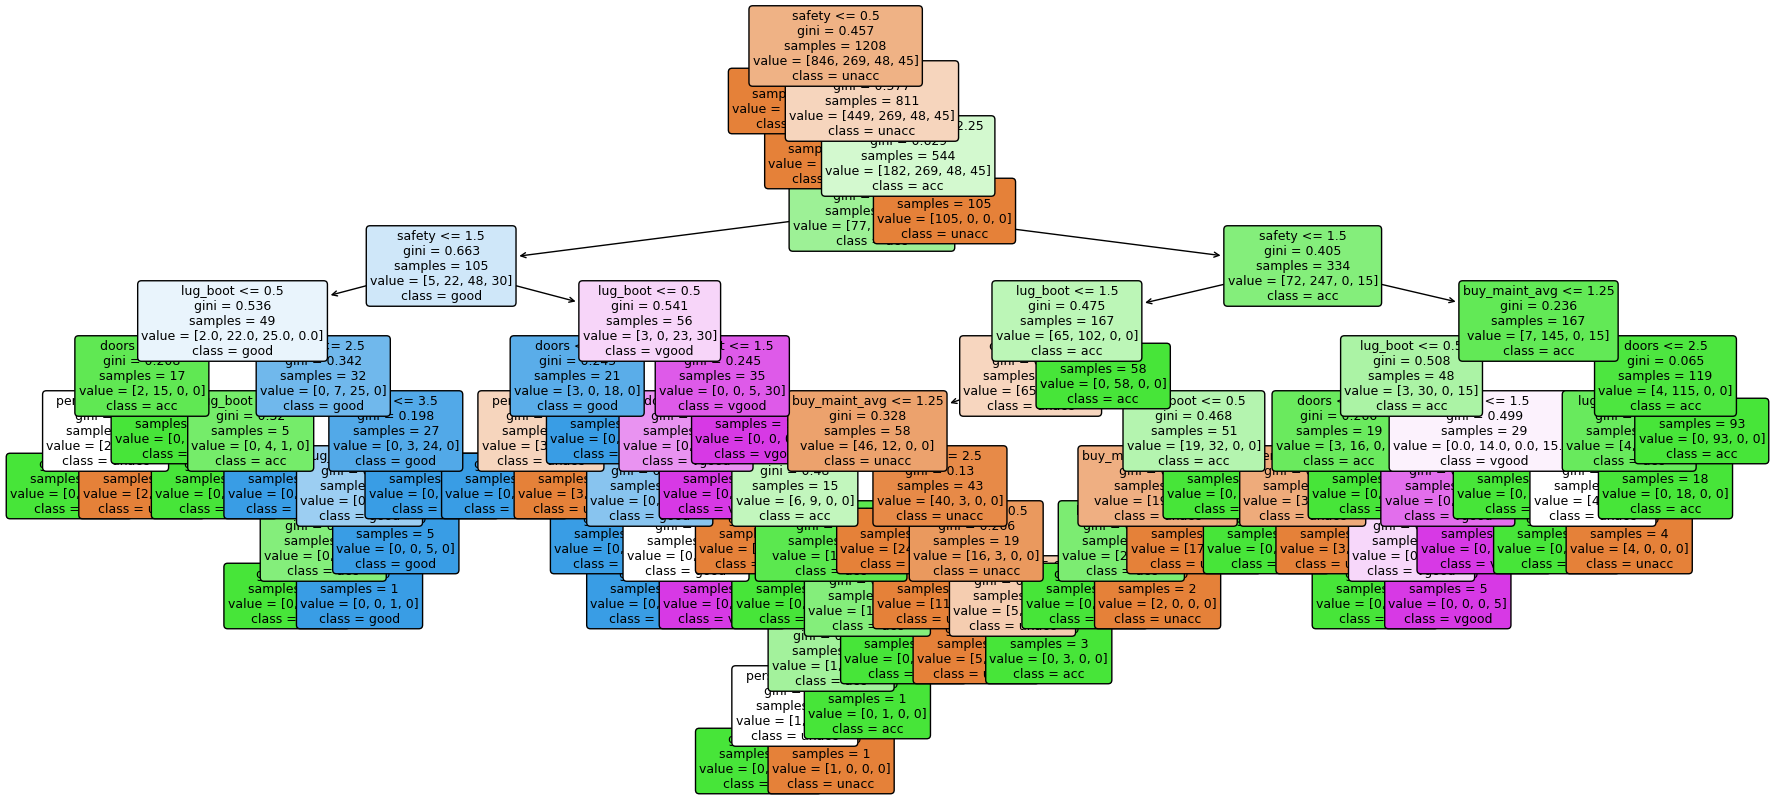

DT Accuracy: 0.9922928709055877


In [13]:
# =====================================================
# Hücre – Decision Tree eğitimi ve görselleştirme
# =====================================================
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# 1) Eğitim/test verisini dönüştür (önceki fonksiyon)
X_train_fe = encode_and_engineer(X_train)
X_test_fe  = encode_and_engineer(X_test)

# 2) Modeli kur ve eğit
dt = DecisionTreeClassifier(
        criterion="gini",     # veya "entropy"
        max_depth=None,       # istersen sınırla (örn. 5)
        random_state=15)
dt.fit(X_train_fe, y_train)

# 3) Görselleştir
plt.figure(figsize=(22,10))
plot_tree(
    dt,
    feature_names=X_train_fe.columns,
    class_names=["unacc","acc","good","vgood"],
    filled=True,
    rounded=True,
    fontsize=9
)
plt.show()

# 4) Basit performans kontrolü
from sklearn.metrics import accuracy_score
print("DT Accuracy:", accuracy_score(y_test, dt.predict(X_test_fe)))


# Karar Ağacı

In [14]:
# =====================================================
# Karar Ağacı modelini tanımla ve eğit
# =====================================================
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=15)
dt_clf.fit(X_train_fe, y_train)


DecisionTreeClassifier(random_state=15)

In [15]:
# =====================================================
# Hücre 10 – Temel model performansı
# =====================================================
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_dt = dt_clf.predict(X_test_fe)

print("DT Accuracy :", accuracy_score(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))


DT Accuracy : 0.9922928709055877

Confusion Matrix:
 [[362   1   0   0]
 [  1 114   0   0]
 [  0   0  21   0]
 [  0   2   0  18]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       363
           1       0.97      0.99      0.98       115
           2       1.00      1.00      1.00        21
           3       1.00      0.90      0.95        20

    accuracy                           0.99       519
   macro avg       0.99      0.97      0.98       519
weighted avg       0.99      0.99      0.99       519



In [16]:
# =====================================================
# Hücre 11 – Hiperparametre optimizasyonu (GridSearchCV)
# =====================================================
from sklearn.model_selection import GridSearchCV

param_grid_dt = {
    "max_depth": [None, 3, 5, 7, 9, 11],
    "min_samples_split": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=15),
    param_grid_dt,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

dt_grid.fit(X_train_fe, y_train)

print("En iyi hiperparametreler:", dt_grid.best_params_)
print("CV Accuracy:", dt_grid.best_score_)


En iyi hiperparametreler: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV Accuracy: 0.9900689276773773


In [17]:
# =====================================================
# Hücre 12 – En iyi model ile test seti skoru
# =====================================================
best_dt = dt_grid.best_estimator_

y_pred_best = best_dt.predict(X_test_fe)

print("Test Accuracy (best DT):", accuracy_score(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Test Accuracy (best DT): 0.9922928709055877

Confusion Matrix:
 [[362   1   0   0]
 [  1 114   0   0]
 [  0   0  21   0]
 [  0   2   0  18]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       363
           1       0.97      0.99      0.98       115
           2       1.00      1.00      1.00        21
           3       1.00      0.90      0.95        20

    accuracy                           0.99       519
   macro avg       0.99      0.97      0.98       519
weighted avg       0.99      0.99      0.99       519



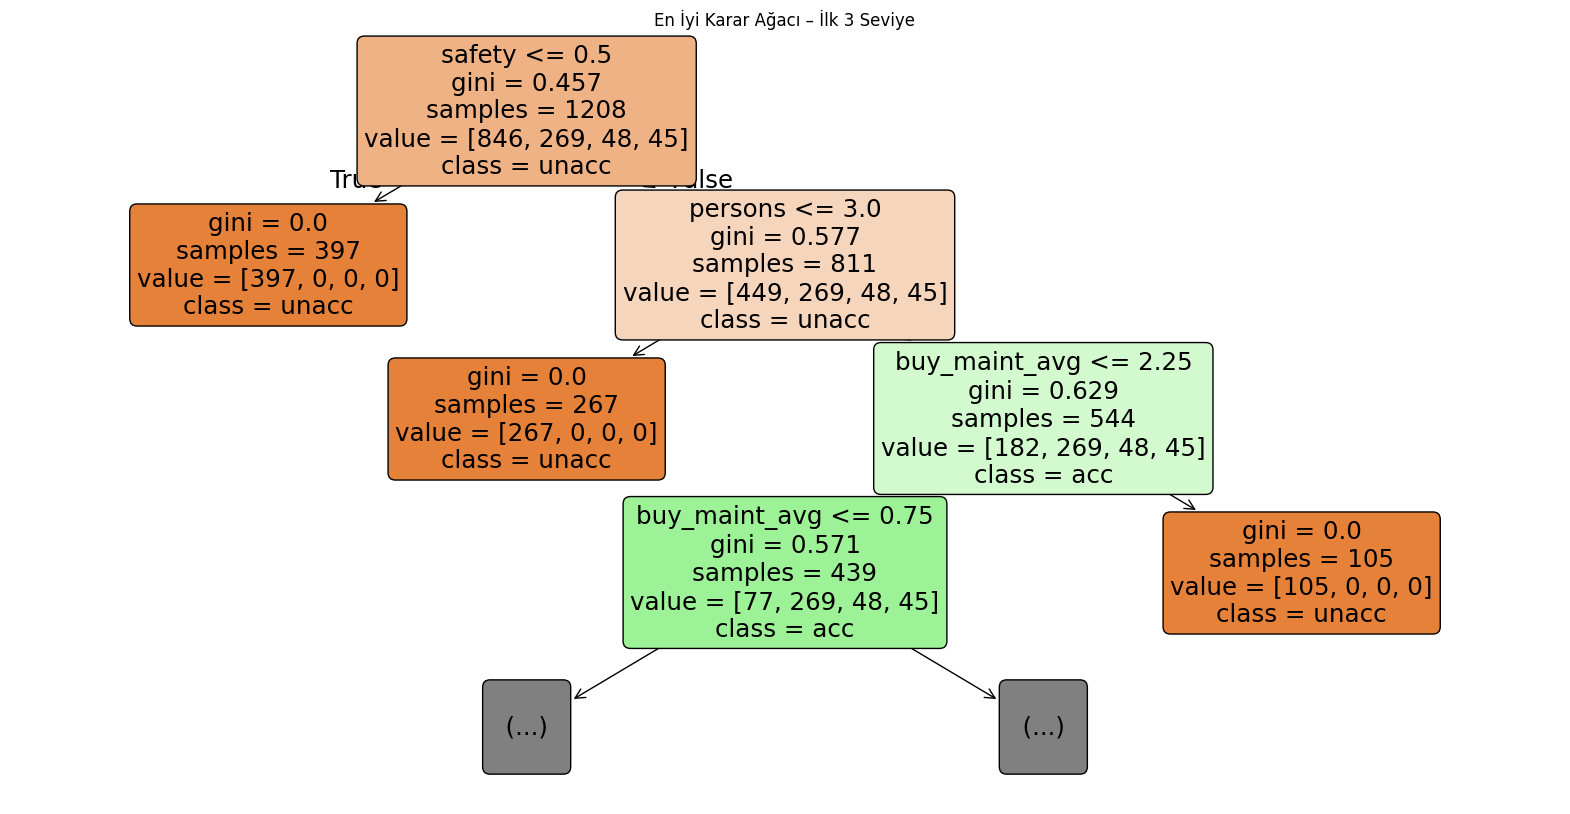

In [18]:
# =====================================================
# Hücre 13 – Karar Ağacını görselleştir
# (Derinliği çok büyükse max_depth parametresini kısıtlayabilirsin.)
# =====================================================
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(best_dt,
          feature_names=X_train_fe.columns,
          class_names=["unacc", "acc", "good", "vgood"],
          filled=True,
          rounded=True,
          max_depth=3   # okunabilirlik için ilk 3 seviye
)
plt.title("En İyi Karar Ağacı – İlk 3 Seviye")
plt.show()


In [19]:
# =====================================================
# Hücre 14 – Özellik önemleri
# =====================================================
import pandas as pd
feat_imp = pd.Series(best_dt.feature_importances_,
                     index=X_train_fe.columns).sort_values(ascending=False)
print(feat_imp)


buy_maint_avg      0.286362
persons            0.258545
safety             0.205590
lug_boot           0.159920
doors              0.058828
buying             0.020430
maint              0.009782
safety_to_price    0.000543
is_family_car      0.000000
dtype: float64
